# 05.01v04 Scanpy Preprocessing

This Jupyter notebook (05.01) details the pipeline for pre-processing of raw single cell data output from Cell Ranger multi using Scanpy.

This is the fifth version (v04) of this notebook. Future changes will be annotated below this line.

 - v00 - Includes steps outlined in the Scanpy clustering tutorial, except when indicated.
 - v01 - Re-analysis with the P1 flow cell chip, better doublet discrimination with scrublet, integrated filtering
 - v02 - Includes cell-cycle scoring
 - v03 - Added scDblFinder scoring and ambient RNA correction, removed scrublet which for some reason does not work.
 - v04 - Isolated variable genes in adata, output full, filtered and variable genes in adata h5ad.


## Initialize Environment
First import all the necessary packages here:

In [1]:
# Import necessary packages
import os
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
import scanpy.external as sce
import matplotlib.pyplot as pl
import anndata2ri
import logging

from matplotlib import colors
from datetime import datetime as dt
from scipy.stats import median_abs_deviation

# Scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()
%matplotlib inline

2023-10-30 00:17:50.937458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.9.5 anndata==0.10.2 umap==0.5.4 numpy==1.24.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.1 statsmodels==0.14.0 igraph==0.11.2 louvain==0.8.1 pynndescent==0.5.10


Identify the starting directory. Get a timestamp for the run. From the timestamp, derive the resulting output h5ad filename.

In [2]:
# Name Variables and Settings
fn = "05.01v04_Data_"       # Filename Prefix
experiment = "D8"                # Experiment batch
savedata = True                         # Save data at the end

# Determine work location
print("The work location for this notebook is: " + os.getcwd() + "\n")

# Get a timestamp for the start of the run
timestamp = dt.now()
print("This notebook was last run on " + timestamp.strftime("%y-%m-%d %H:%M") + " UTC\n")

# Determine the filename for the expected output h5ad
fn = fn + timestamp.strftime("%y-%m-%d-%H-%M")
print("The filename for the AnnData output of this notebook will be:")
print(fn + "_preprocessing.h5ad")
print("which will be saved in the WORKDIR/h5ad/ folder.")

The work location for this notebook is: /home/dsalbao/work/2023-020-Diao-Reanalysis/D8_03_scanpy

This notebook was last run on 23-10-30 00:17 UTC

The filename for the AnnData output of this notebook will be:
05.01v04_Data_23-10-30-00-17_preprocessing.h5ad
which will be saved in the WORKDIR/h5ad/ folder.


The work directory is structured to contain a folder named "outs" which itself contains output from the Cell Ranger multi pipeline. "outs" contains demultiplexed data.

In [3]:
# List items in outs folder
# The item names should correspond to sample names
sample_names = os.listdir("outs")
sample_names.sort()
print(sample_names)

['DP', 'EE', 'MP', 'Naive', 'TE']


Go through all the samples in sample_names and then load the data into a new object in Python. This differs from the tutorial in that the different samples which were multiplexed will be loaded and initially pre-processed seprately before concatenating them and performing normalization.

In [4]:
samples = [] # Array to contain the AnnData for each of the individual groups

### MANUAL ANNOTATION
infection = ["Arm", "Arm", "Arm", "Naive", "Arm"]
timepoint = ["Day 8", "Day 8", "Day 8", "Naive", "Day 8"]

# Loop through all samples in sample_names
for index in range(0, len(sample_names)):
    
    # Load samples individually into each array element
    samples.append(sc.read_10x_mtx("outs/" + sample_names[index] + "/count/sample_filtered_feature_bc_matrix"))

    # Annotate each sample with the experiment as a group observation
    samples[index].obs["experiment"] = experiment
    # Annotate each sample with the sample name as a group observation
    samples[index].obs["group"] = sample_names[index]
    # Annotate each sample with the timepoint as a group observation
    samples[index].obs["timepoint"] = infection[index]
    # Annotate each sample with the infection as a group observation
    samples[index].obs["infection"] = timepoint[index]

    # Check output
    samples[index]
# End loop

del(index) # Cleanup

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Then combine all samples into one adata file:

In [5]:
# Set the first element in the array as the base
adata = samples[0]

# Concatenate sample on top of the base
# Start from sample 1, since adata already contains sample 0 
for index in range(1, len(sample_names)):
    adata = ad.concat([adata, samples[index]], join = "outer") # Outer option does a union of all genes
# End loop

# Confirm resulting AnnData file then cleanup
print(adata)
del(samples, index)

AnnData object with n_obs × n_vars = 15945 × 32285
    obs: 'experiment', 'group', 'timepoint', 'infection'


## Basic pre-processing

For basic quality control metrics, plot the highest expressed genes per sample:

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


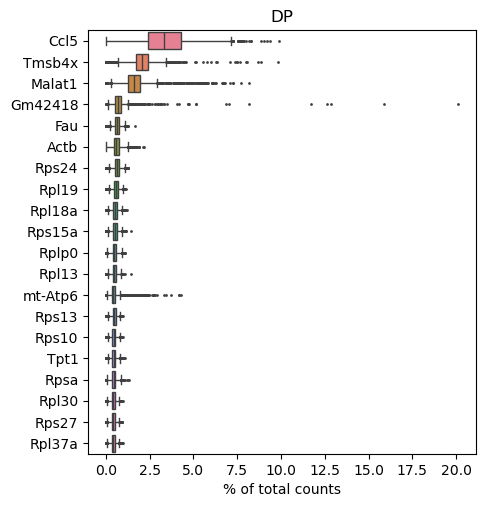

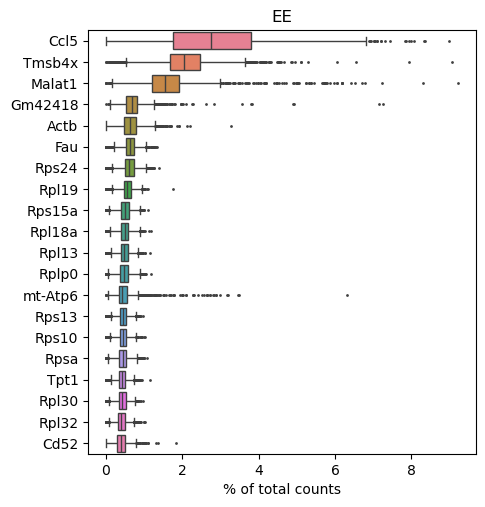

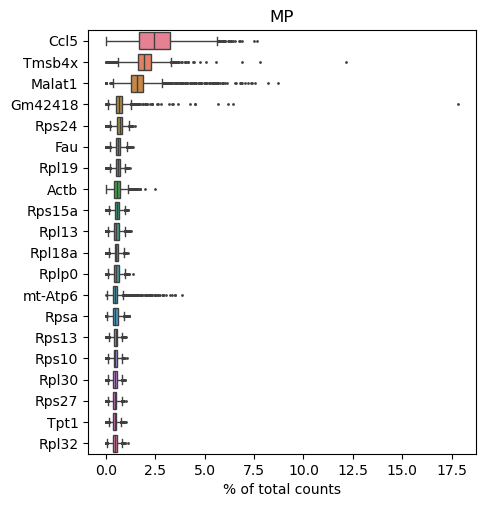

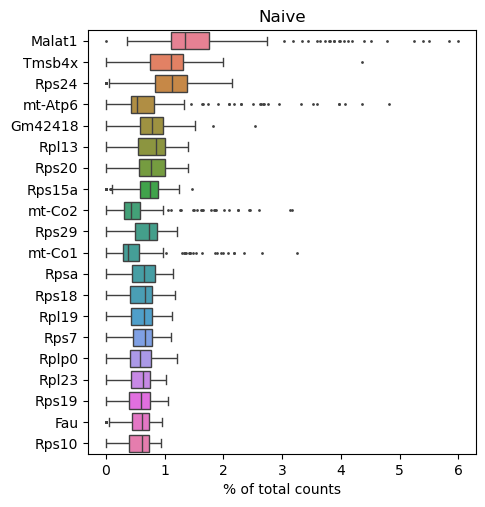

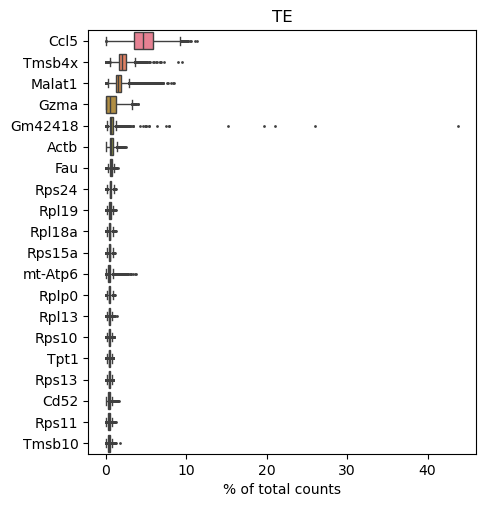

In [6]:
# Plot highest expressed genes per sample
for group in sample_names:
    %matplotlib inline
    plot = sc.pl.highest_expr_genes(adata[adata.obs.group == group, :], n_top=20, show = False)
    plot.set_title(group)
# End of loop

del(plot) # Cleanup

## Filtering

Create filters for outliers based on counts and number of genes expressed and filter genes based on number of cells or counts.

But first, check the original metric

In [7]:
print(adata)

AnnData object with n_obs × n_vars = 15945 × 32285
    obs: 'experiment', 'group', 'timepoint', 'infection'


Compute quality metrics:

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legen

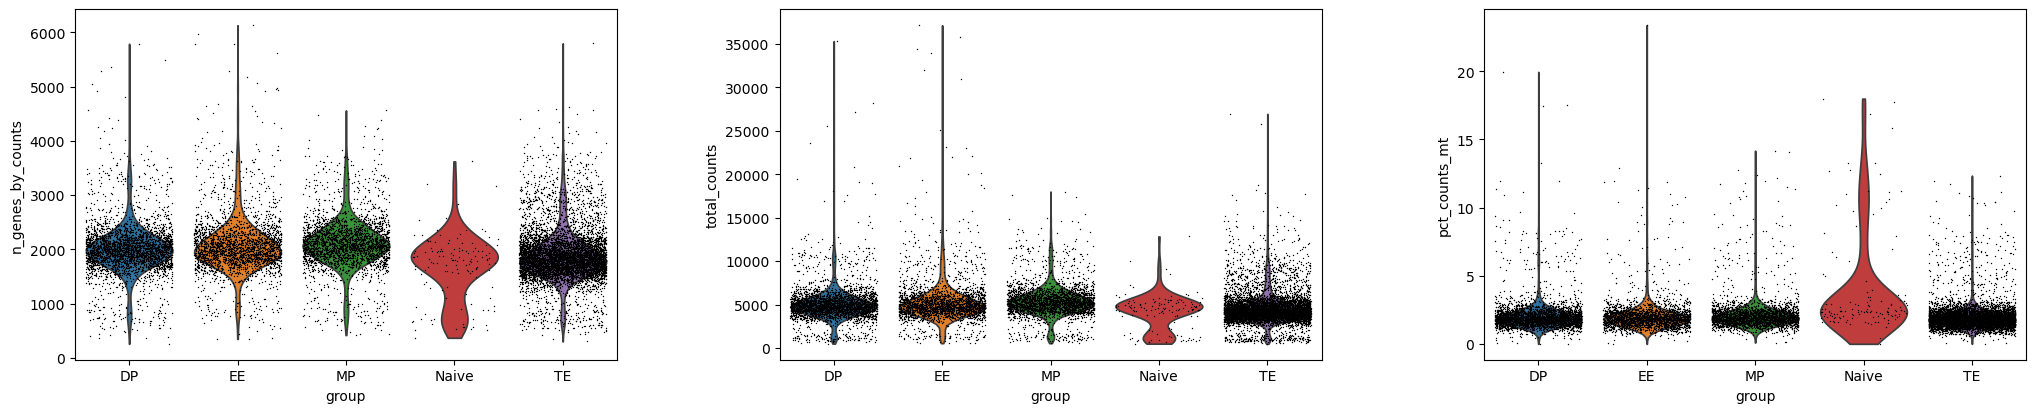

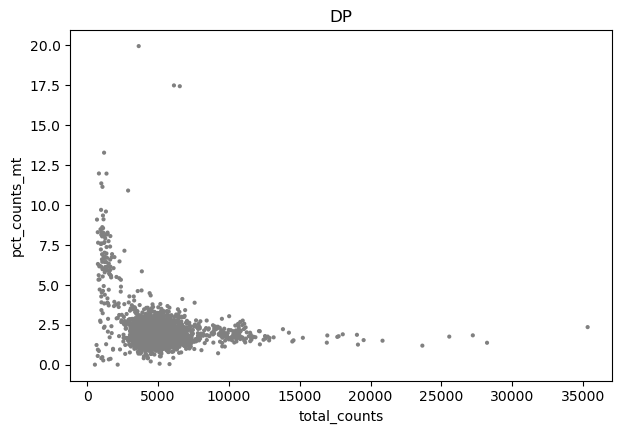

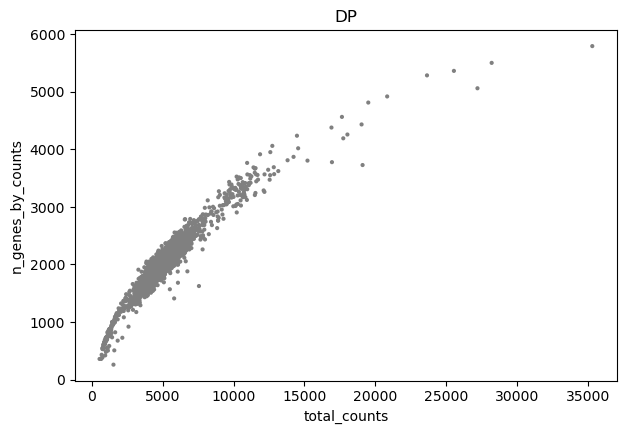

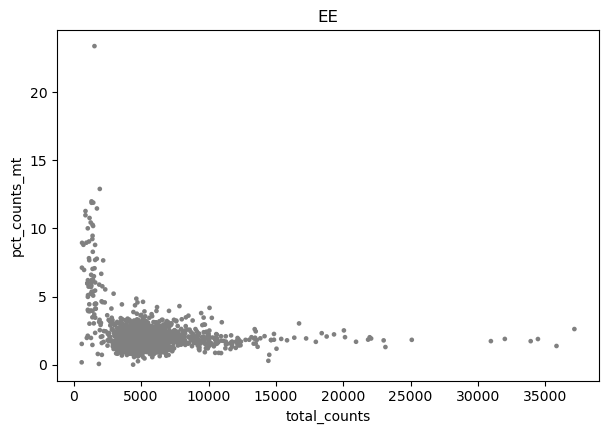

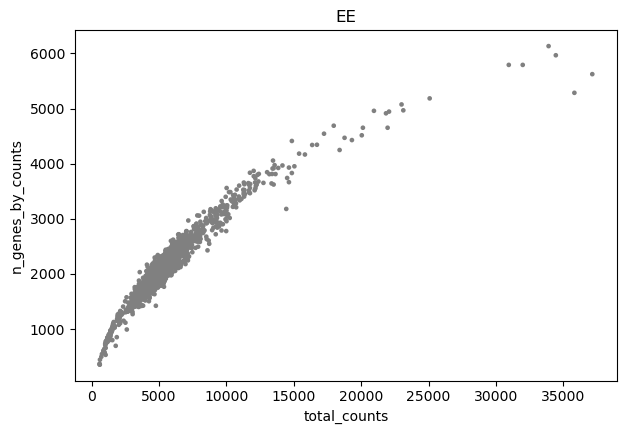

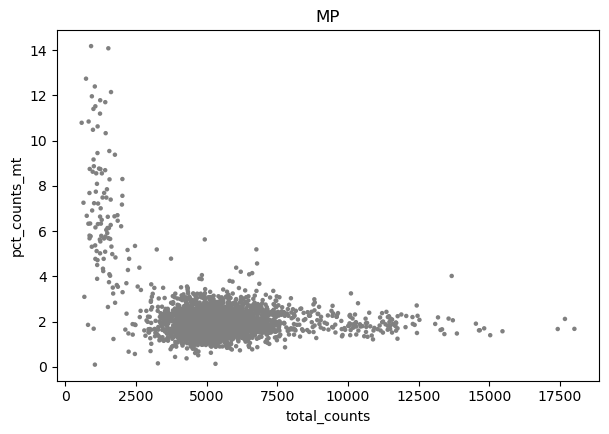

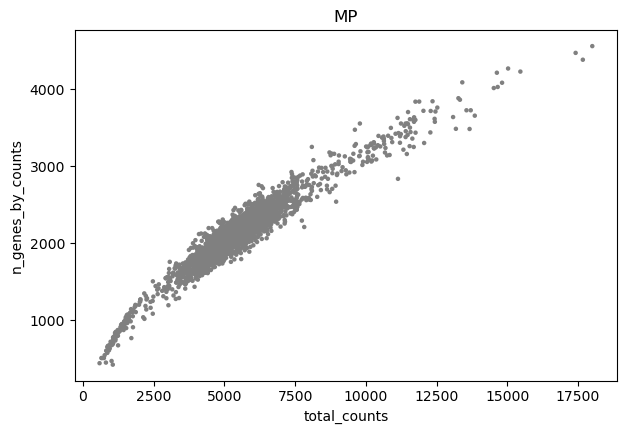

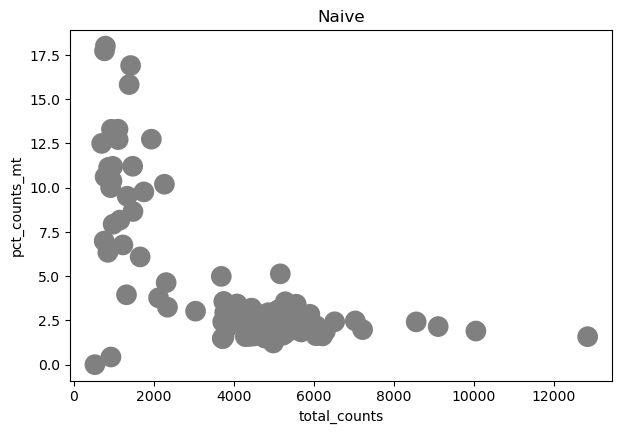

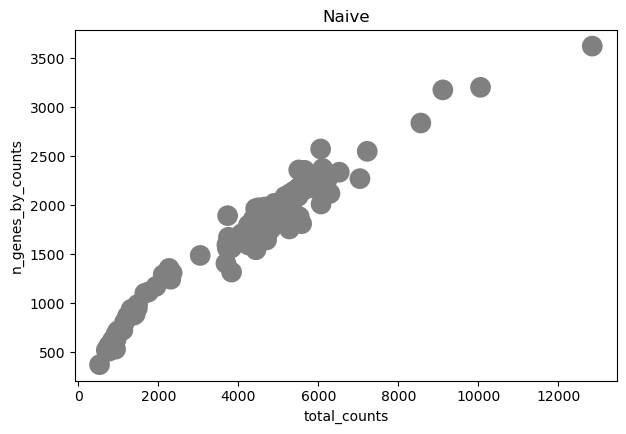

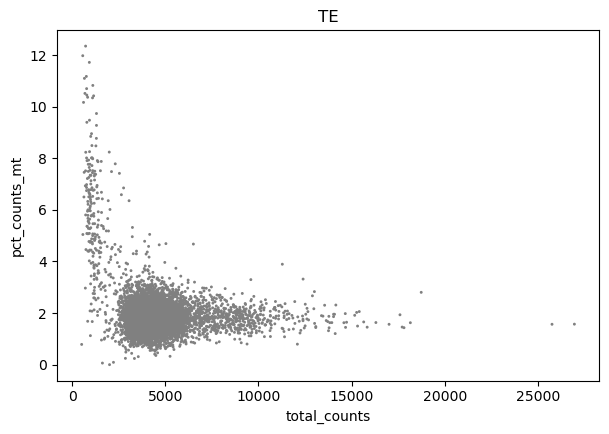

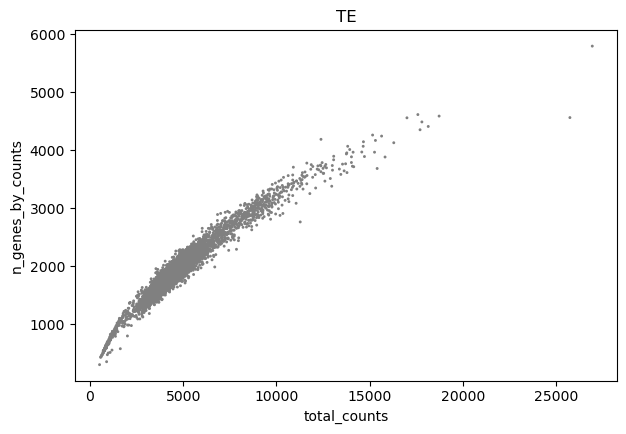

In [8]:
# Mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# Ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))

# Calculate percent mitochondrial gene contamination
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=True, inplace=True)

# Plot quality metrics:
%matplotlib inline
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= "group", jitter=0.4, multi_panel=True)

for group in sample_names:
    %matplotlib inline
    sc.pl.scatter(adata[adata.obs.group == group, :], x='total_counts', y='pct_counts_mt', title = group)
    sc.pl.scatter(adata[adata.obs.group == group, :], x='total_counts', y='n_genes_by_counts', title = group)
# End of loop

del(group) # Cleanup

Now for each sample in the array "samples" do the following:

1) Correct for ambient RNA.
2) Do doublet discrimination with scrublet and scDblFinder and mark doublets, but do not filter yet!
3) Create low-level filters.
4) High-level filtering:
 - remove cells with less than 200 genes
 - genes expressed in less than 3 cells
 - genes with less than 5 counts
5) Do low level filtering by removing high MT contamination, doublets and low counts.

### Ambient RNA correction

First import packages to run R on the notebook:

In [9]:
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

SoupX requires basic clustering data and raw data, so do that:

In [10]:
# Make adata copy then normalize
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

# Do dimensionality reduction
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Extract groups
soupx_groups = adata_pp.obs["soupx_groups"]

# Cleanup, remove extra adata
del adata_pp

# Prepare data for SoupX
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

# Import raw data needed for SoupX
adata_raw = sc.read_10x_h5(filename="raw_feature_bc_matrix.h5")
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T
del adata_raw

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:23)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
running Leiden clustering
    finished: found 12 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:01)
reading raw_feature_bc_matrix.h5
 (0:00:02)


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Call the R function:

In [11]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 
library(SoupX)

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SboupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Take the outputs from R and reassign to adata:

In [12]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]

### Doublet Discrimination

Analyze using scrublet and scDblFinder:

In [13]:
# Doublet discrimination with scrublet
sce.pp.scrublet(
    adata,
    adata_sim = None,
    threshold=0.2,
)
sce.pl.scrublet_score_distribution(adata)

Running Scrublet
filtered out 14826 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Detected doublet rate = 4.3%
Estimated detectable doublet fraction = 32.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 13.1%
    Scrublet finished (0:00:13)


/opt/conda/lib/python3.10/site-packages/scanpy/external/pl.py:419: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for idx, (batch_key, sub_obs) in enumerate(adata.obs.groupby(batches)):


/opt/conda/lib/python3.10/site-packages/scanpy/external/pl.py:419: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for idx, (batch_key, sub_obs) in enumerate(adata.obs.groupby(batches)):


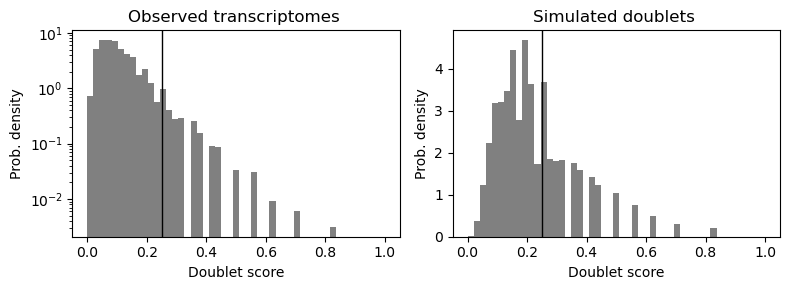

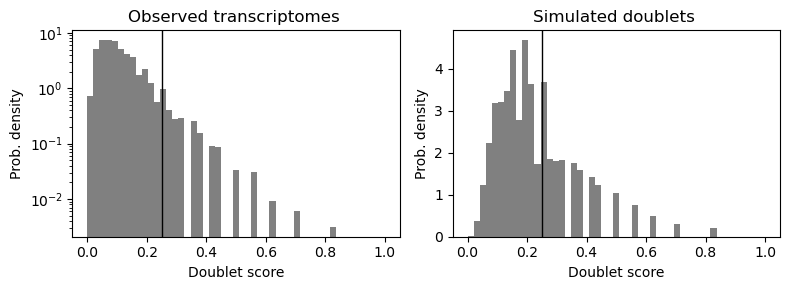

In [14]:
%matplotlib inline
sce.pl.scrublet_score_distribution(adata)

Do another doublet discrimination technique using scDblDinder:

In [15]:
# Doublet discrimination by scDblFinder
# First extract matrix:
data_mat = adata.X.T

Import R functions to score doublets:

In [16]:
%%R -i data_mat -o doublet_score -o doublet_class

library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [17]:
# Reassign scDblFinder scores into data:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    14609
doublet     1336
Name: count, dtype: int64

### Create low-level filters

In [18]:
# Create Filters
conditions = [
    (adata.obs['predicted_doublet'] == True),
    (adata.obs['scDblFinder_class'] == "doublet"),
    (adata.obs['n_genes_by_counts'] < 1250),
    (adata.obs['total_counts'] < 3000),
    (adata.obs['pct_counts_mt'] > 5),
    (adata.obs['pct_counts_mt'] <= 5) & (adata.obs['n_genes_by_counts'] >= 1250) & (adata.obs['total_counts'] >= 3000) & (adata.obs['scDblFinder_class'] == "singlet") & (adata.obs['predicted_doublet'] == False)]

values = [ 
            'Doublet_Scrublet', 
            'Doublet_scDblFinder', 
            'Low_nFeature', 
            'Low_counts', 
            'High_MT', 
            'Pass']
adata.obs['QC'] = np.select(conditions, values)
adata.obs['QC'] = adata.obs['QC'].astype('category')

# Filters
adata.obs['QC'].value_counts()

QC
Pass                   13101
Doublet_scDblFinder     1183
Doublet_Scrublet         684
Low_nFeature             640
Low_counts               326
High_MT                   11
Name: count, dtype: int64

### Filter

In [19]:
# High level filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=5)

# Filtering
adata_doublet = adata[ ((adata.obs['QC'] == 'Pass') |
                       (adata.obs['QC'] == 'Doublet_scDblFinder') |
                       (adata.obs['QC'] == 'Doublet_Scrublet')) &
                       (adata.obs['n_genes_by_counts'] >= 1250) &
                       (adata.obs['total_counts'] >= 3000) &
                    (adata.obs['pct_counts_mt'] <= 5), :] #Create copy of adata with doublets for analysis
adata = adata[adata.obs['QC'] == 'Pass', :]

filtered out 14826 genes that are detected in less than 3 cells
filtered out 1121 genes that are detected in less than 5 counts


## Post-Filtering

Check sample names:

In [20]:
# Check if sample labeling carried over
print("Singlets:")
print(adata)
print(adata.obs['group'].value_counts())
print("With Doublets:")
print(adata_doublet)
print(adata_doublet.obs['group'].value_counts())

Singlets:
View of AnnData object with n_obs × n_vars = 13101 × 16338
    obs: 'experiment', 'group', 'timepoint', 'infection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'QC', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts'
    uns: 'group_colors', 'scrublet'
    layers: 'counts', 'soupX_counts'
group
TE       5556
DP       2751
MP       2463
EE       2231
Naive     100
Name: count, dtype: int64
With Doublets:
View of AnnData object with n_obs × n_vars = 14965 × 16338
    obs: 'experiment', 'group', 'timepoint', 'infection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'tota

Check the resulting quality metrics of the combined samples:

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legen

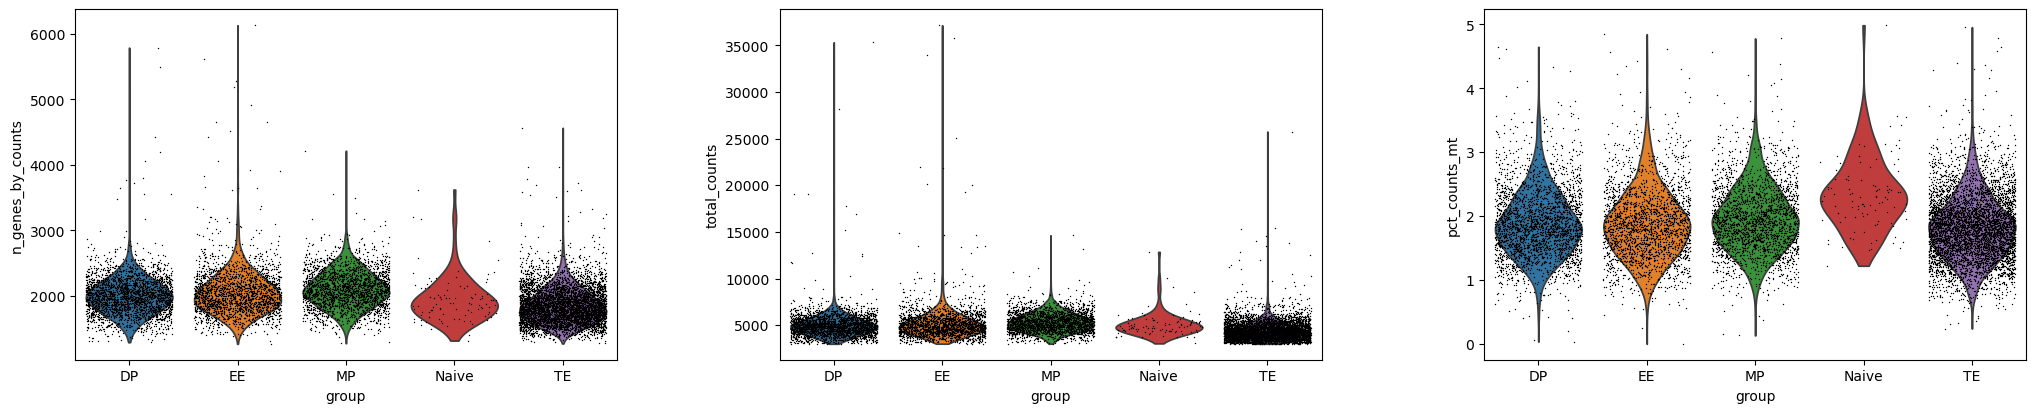

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


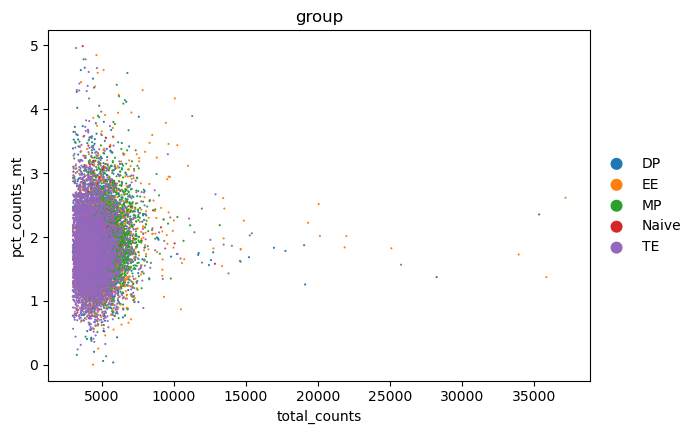

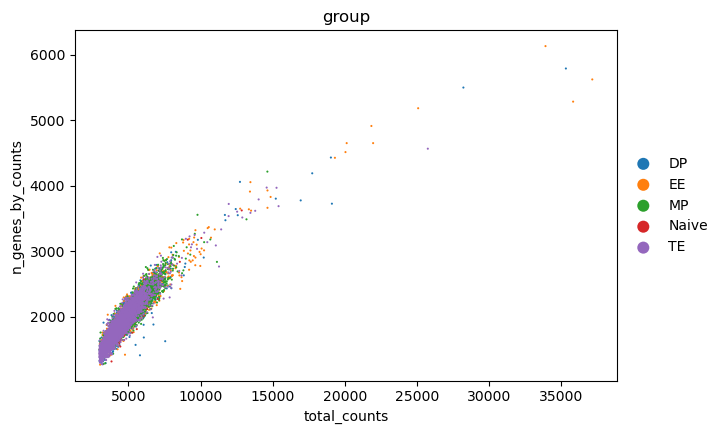

In [21]:
# Plot combined QC metrics, grouped by sample (singlet filtered)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= "group", jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = "group")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = "group")

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legen

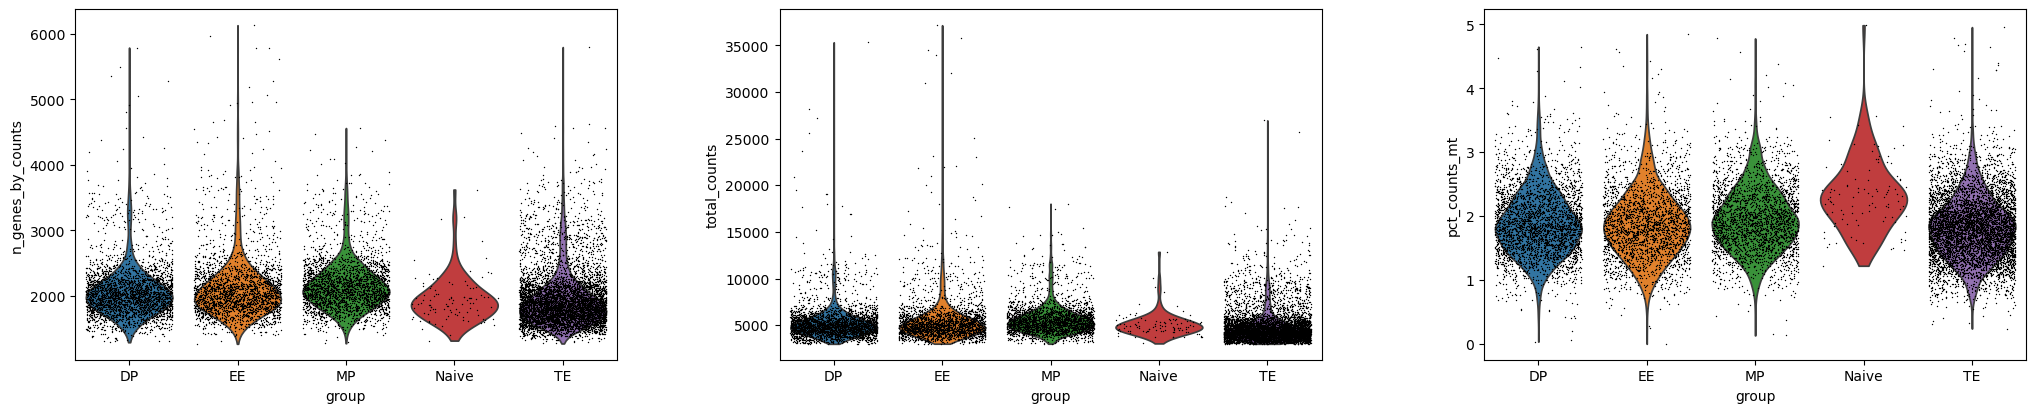

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


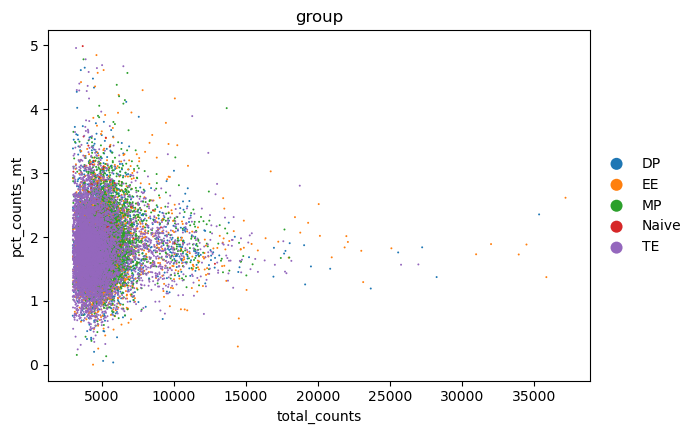

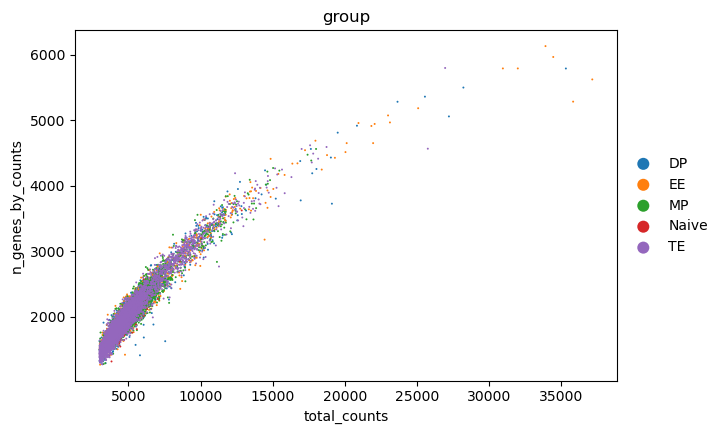

In [22]:
# Plot combined QC metrics, grouped by sample (with doublets)
sc.pl.violin(adata_doublet, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= "group", jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_doublet, x='total_counts', y='pct_counts_mt', color = "group")
sc.pl.scatter(adata_doublet, x='total_counts', y='n_genes_by_counts', color = "group")

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


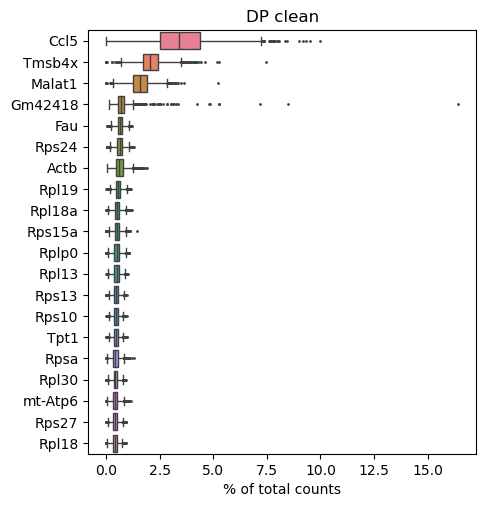

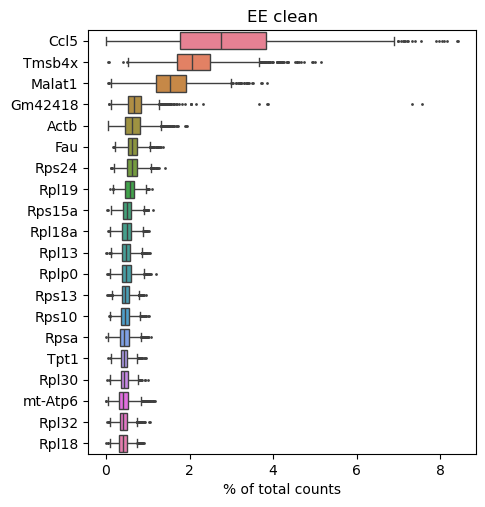

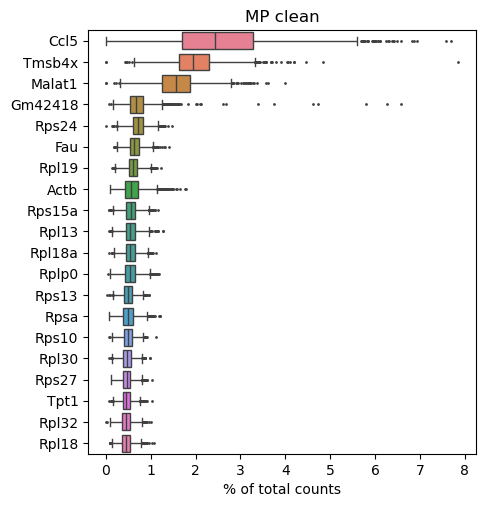

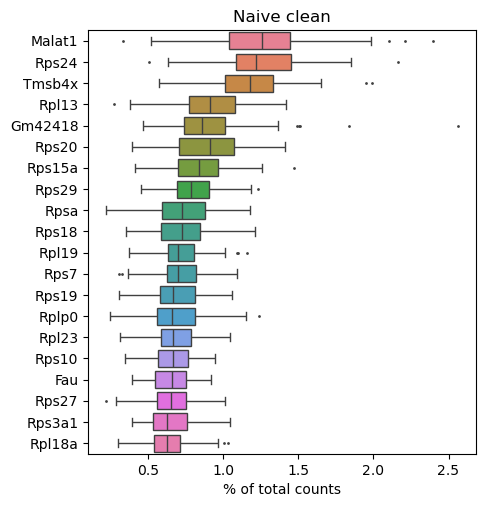

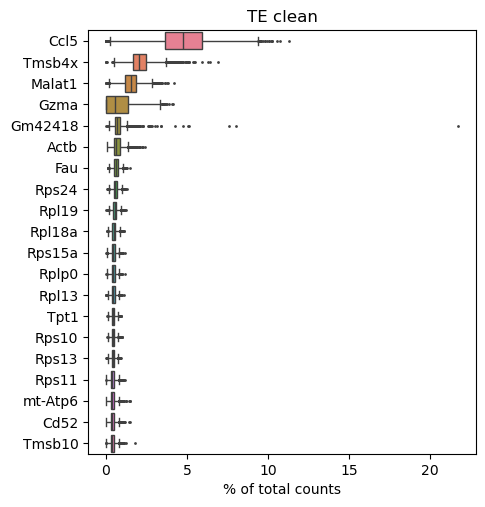

In [23]:
# Plot highest expressed genes per sample
for group in sample_names:
    plot = sc.pl.highest_expr_genes(adata[adata.obs.group == group, :], n_top=20, show = False)
    plot.set_title(group + " clean")
# End of loop

del(plot) # Cleanup

## Cell Cycle Regression

These steps socre cell cycle effects and regress these effects out.

In [24]:
# Load S genes
s_genes =  [x.strip() for x in open('../mouse-s-gene-list.csv')]
print(s_genes)

# Load G2M genes
g2m_genes =  [x.strip() for x in open('../mouse-g2m-gene-list.csv')]
print(g2m_genes)

# Score cells for cell cycle
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes) # Score filtered adata
sc.tl.score_genes_cell_cycle(adata_doublet, s_genes=s_genes, g2m_genes=g2m_genes) # Score adata with doublets

['Rrm2', 'Mcm4', 'Gmnn', 'Exo1', 'Mrpl36', 'Uhrf1', 'Chaf1b', 'Cdc45', 'Msh2', 'Cdc6', 'Slbp', 'Rad51ap1', 'Cenpu', 'Ubr7', 'Dscc1', 'Hells', 'Fen1', 'Prim1', 'Mcm6', 'Wdr76', 'Ung', 'Mcm5', 'Blm', 'Pola1', 'Clspn', 'Usp1', 'Tipin', 'Gins2', 'Nasp', 'Dtl', 'Cdca7', 'Tyms', 'Pcna', 'Rfc2', 'Polr1b', 'Casp8ap2', 'Rrm1', 'Rad51', 'Ccne2', 'Mcm7', 'E2f8']
['Cbx5', 'Cdc25c', 'Dlgap5', 'Gtse1', 'Smc4', 'Ctcf', 'Kif20b', 'Cdca2', 'Top2a', 'Hmgb2', 'Cdk1', 'Ncapd2', 'G2e3', 'Ttk', 'Tacc3', 'Ckap2', 'Cks2', 'Gas2l3', 'Cdca3', 'Anp32e', 'Kif2c', 'Ccnb2', 'Kif23', 'Anln', 'Psrc1', 'Ect2', 'Hmmr', 'Tpx2', 'Aurkb', 'Cdca8', 'Kif11', 'Cdc20', 'Rangap1', 'Cks1b', 'Cenpf', 'Hjurp', 'Cenpe', 'Lbr', 'Birc5', 'Ndc80', 'Nek2', 'Cenpa', 'Aurka', 'Jpt1', 'Nuf2', 'Ube2c', 'Tubb4b', 'Ckap2l', 'Pimreg', 'Mki67', 'Ckap5', 'Bub1', 'Nusap1']
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    612 total control genes are used. (0:00:00)
compu

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


    finished: added
    'G2M_score', score of gene set (adata.obs).
    733 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
calculating cell cycle phase
computing score 'S_score'


/opt/conda/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


    finished: added
    'S_score', score of gene set (adata.obs).
    614 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    738 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


## Normalization

Steps from here and onwards describe normalization steps prior to clustering analyses.

The first step is to normalize cell counts to 20,000 reads per cell. We choose this number based on the Day 5 sample distribution.

In [25]:
# Normalize read counts
sc.pp.normalize_total(adata, target_sum=2e4) # cell filtered
sc.pp.normalize_total(adata_doublet, target_sum=2e4) # cell doublets

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


Then logarithmize the data:

In [26]:
# Change to logarithmic scale
sc.pp.log1p(adata) # cell filtered
sc.pp.log1p(adata_doublet) # cell doublets

Then identify highly-variable genes and plot:

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


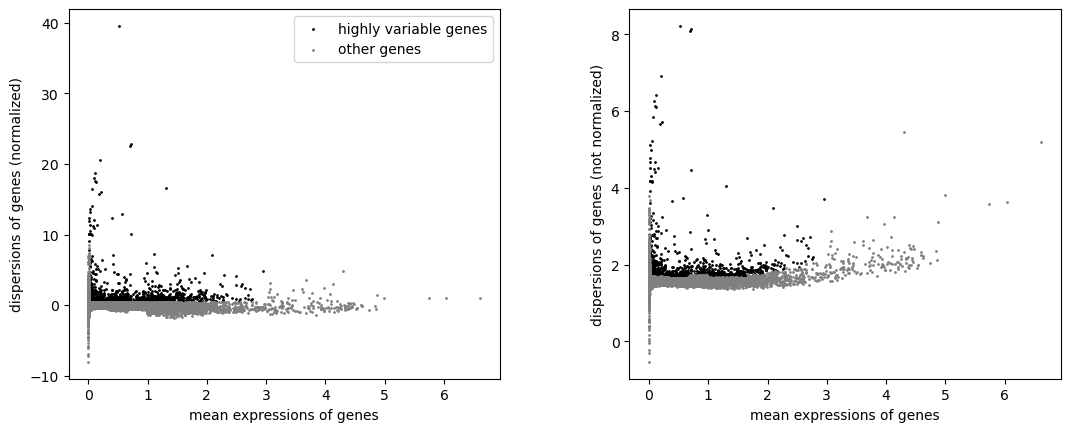

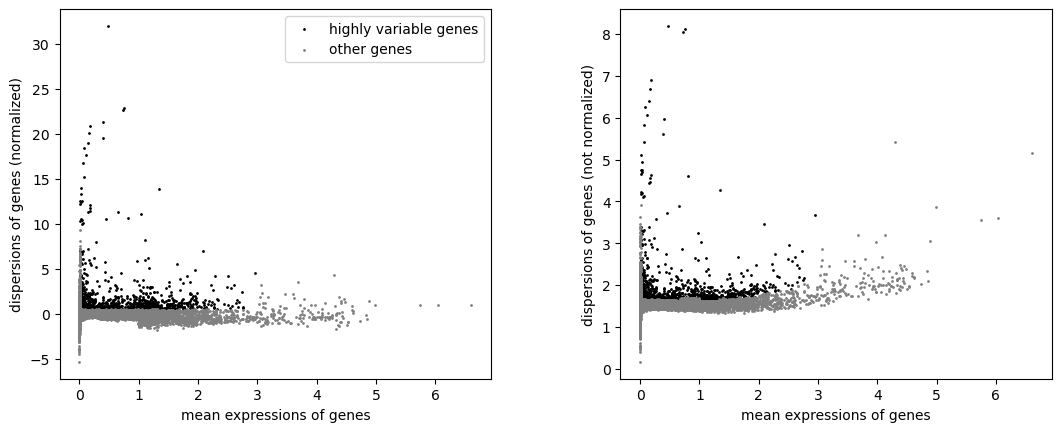

In [27]:
# Identify variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata_doublet, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Plot variable genes
%matplotlib inline
sc.pl.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata_doublet)

# Keep only variable genes
adata_singlet = adata # Make a copy with all genes
adata = adata[:, adata.var.highly_variable]

Set the raw attribute of AnnData as the normalized values, which is done prior to regression of count effects. This allows recovery of raw normalized data prior to correction:

In [28]:
# Store raw data
adata.raw = adata
adata_singlet.raw = adata_singlet
adata_doublet.raw = adata_doublet

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance. In this step, I skipped filtering by highly variable genes that is present in the Scanpy tutorial, as I am interested in all genes.

In [29]:
# Regress out the effects of cell count and mitochondrial contamination
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
sc.pp.regress_out(adata_singlet, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
sc.pp.regress_out(adata_doublet, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
# Lastly, scale the data
sc.pp.scale(adata)
sc.pp.scale(adata_singlet)
sc.pp.scale(adata_doublet)
# Check the resulting AnnData object
print("Filtered:")
print(adata)
print("Singlets, all genes:")
print(adata_singlet)
print("With doublets, all genes:")
print(adata_doublet)

regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:00:09)
regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:02:46)
regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:03:06)
Filtered:
AnnData object with n_obs × n_vars = 13101 × 1103
    obs: 'experiment', 'group', 'timepoint', 'infection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'QC', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'group_colors', 'scrublet', 'log1p', 'hvg'
    layers: 'counts', 'soupX_counts'
Singlets, all genes:
AnnData object with n_obs × n_vars = 13101 × 16338
    obs: 'experiment', 'group', 'timepoint', 'infection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total

## Principal Component Analysis

We can now do the preliminary steps prior to clustering analyses since the data is normalized and regressed. Start by identifying principal components:

In [30]:
# Compute principal components
sc.tl.pca(adata, svd_solver='arpack', n_comps = 75)
sc.tl.pca(adata_singlet, svd_solver='arpack', n_comps = 75)
sc.tl.pca(adata_doublet, svd_solver='arpack', n_comps = 75)

computing PCA
    on highly variable genes
    with n_comps=75
    finished (0:00:02)
computing PCA
    on highly variable genes
    with n_comps=75
    finished (0:00:02)
computing PCA
    on highly variable genes
    with n_comps=75
    finished (0:00:02)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


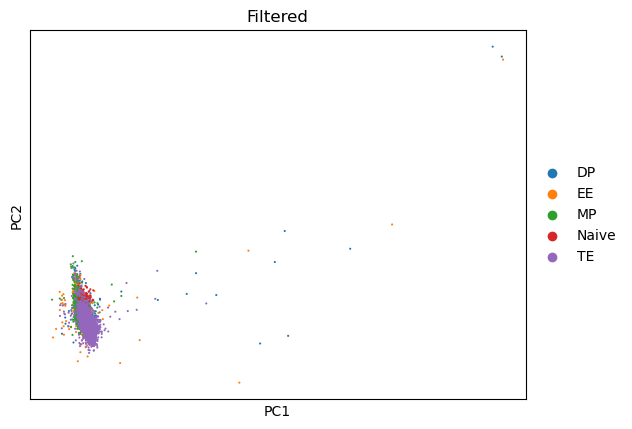

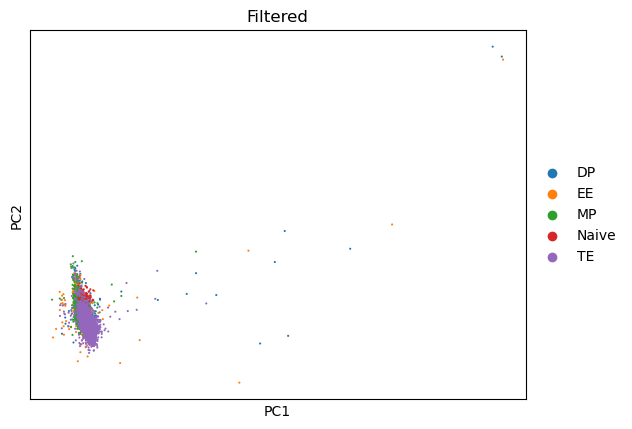

In [31]:
# Plot
%matplotlib inline
sc.pl.pca(adata, color='group', return_fig = True, title = "Filtered")

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


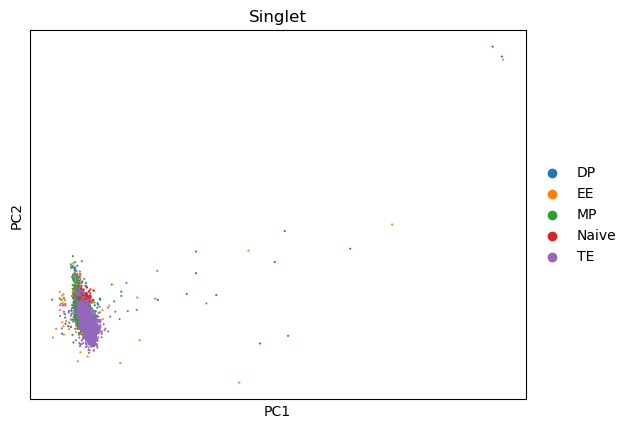

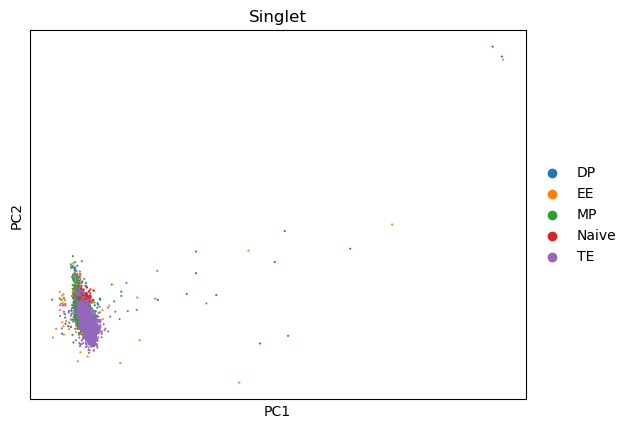

In [32]:
# Plot
%matplotlib inline
sc.pl.pca(adata_singlet, color='group', return_fig = True, title = "Singlet")

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


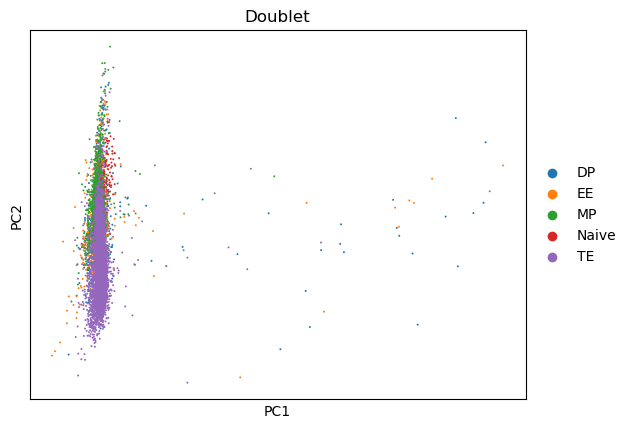

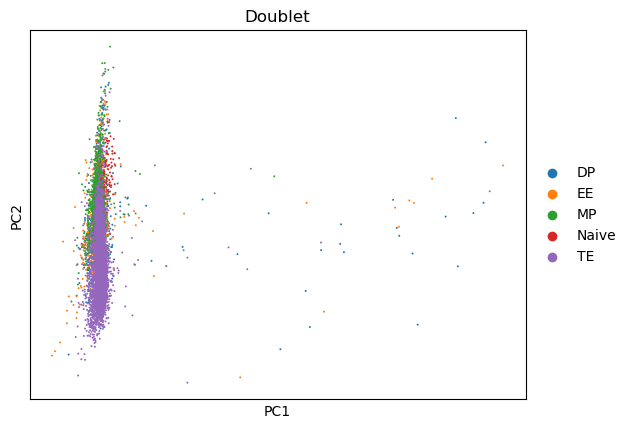

In [33]:
# Plot
%matplotlib inline
sc.pl.pca(adata_doublet, color='group', return_fig = True, title = "Doublet")

Identify the contribution of each principal component to variance through a Scree plot:

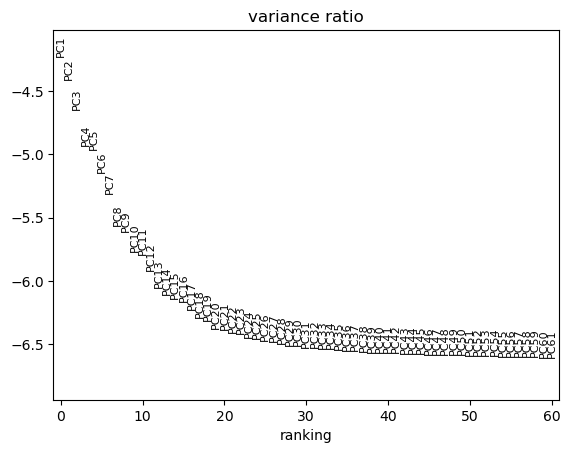

In [34]:
# Plot the Scree plot:
%matplotlib inline
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 60)

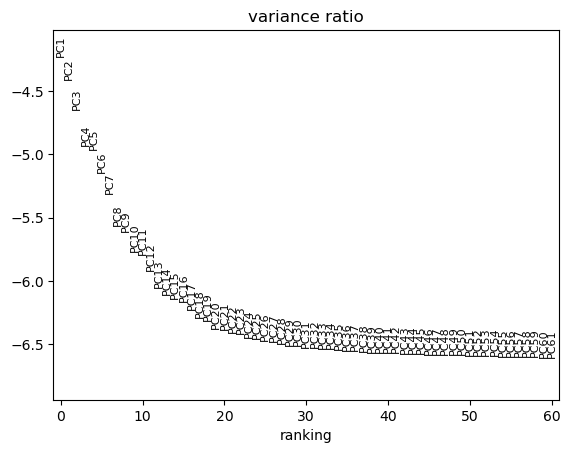

In [35]:
# Plot the Scree plot:
%matplotlib inline
sc.pl.pca_variance_ratio(adata_singlet, log=True, n_pcs = 60)

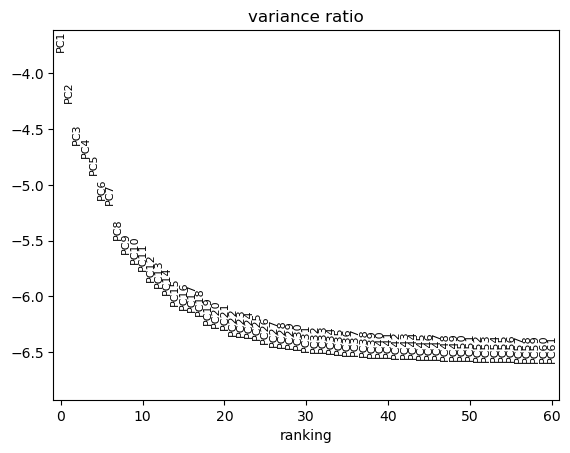

In [36]:
# Plot the Scree plot:
%matplotlib inline
sc.pl.pca_variance_ratio(adata_doublet, log=True, n_pcs = 60)

## Save Data
Procedures for saving data are outlined below:

In [37]:
# Reminder for the saved data
if savedata:

    print("The AnnData outputs of this notebook will be saved in the h5ad/ folder.")
    
    # Save data to an AnnData file
    print("adata Filtered:" + fn + "_" + "filtered" +"_preprocessing.h5ad")
    adata.write_h5ad(filename = "h5ad/" + fn + "_" + "filtered" +"_preprocessing.h5ad", compression = "gzip", compression_opts = 9)
    print(adata)

    # Save data to an AnnData file
    print("adata Singlet:" + fn + "_" + "singlet" +"_preprocessing.h5ad")
    adata_singlet.write_h5ad(filename = "h5ad/" + fn + "_" + "singlet" +"_preprocessing.h5ad", compression = "gzip", compression_opts = 9)
    print(adata)

    # Save data to an AnnData file
    print("adata Doublet:" + fn + "_" + "doublet" +"_preprocessing.h5ad")
    adata_doublet.write_h5ad(filename = "h5ad/" + fn + "_" + "doublet" +"_preprocessing.h5ad", compression = "gzip", compression_opts = 9)
    print(adata)

else:

    print("Not saving the AnnData file!")
    
# End of Notebook
print("\nNotebook Ends")

The AnnData outputs of this notebook will be saved in the h5ad/ folder.
adata Filtered:05.01v04_Data_23-10-30-00-17_filtered_preprocessing.h5ad
AnnData object with n_obs × n_vars = 13101 × 1103
    obs: 'experiment', 'group', 'timepoint', 'infection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'QC', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'group_colors', 'scrublet', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'soupX_counts'
adata Singlet:05.01v04_Data_23-1